In [166]:
import psycopg2
import pandas as pd
import psycopg2.extras
 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, normalize

from sklearn.linear_model import  LinearRegression

In [167]:
class PostgresConnection(object):
    def __init__(self):
        self.connection = psycopg2.connect(database="ecomdb",
                                           user = "postgres",
                                           password = "123456",
                                           host = "127.0.0.1",
                                           port = "5432")

    def getConnection(self):
        print("successfully connected to database")
        return self.connection
    
    
# con = PostgresConnection().getConnection()    

### Common Function to fetch Data from all tables 

In [168]:

#  select_stmt= is the SQL select query along with  table and column name    
def retrive_data_from_table(select_stmt): 
    con = PostgresConnection().getConnection()
    cur = con.cursor()
    #select_stmt = select_stmt = "SELECT * FROM :{} ".formate(tablename)
    cur.execute(select_stmt)
    records = cur.fetchall()
    return records


In [169]:
select_stmt = "select t4.item_key, t2.month, t2.year, sum(t1.total_price) "\
              "from ecomdb_star_schema.fact_table t1 "\
              "join ecomdb_star_schema.time_dim t2 on t1.time_key = t2.time_key "\
              "join ecomdb_star_schema.item_dim t4 on t4.item_key = t1.item_key "\
              "group by(t4.item_key, t2.month, t2.year) "\

records = retrive_data_from_table(select_stmt)
df = pd.DataFrame(list(records), columns=['Item', 'Month', 'year', 'Total Sales'])

df

successfully connected to database


,Item,Month,year,Total Sales
0,I00001,1,2014,1518.0
1,I00001,1,2015,3473.0
2,I00001,1,2016,3036.0
3,I00001,1,2017,3438.5
4,I00001,1,2018,3990.5
...,...,...,...,...
22435,I00264,12,2016,3555.0
22436,I00264,12,2017,3465.0
22437,I00264,12,2018,4680.0
22438,I00264,12,2019,3600.0


In [170]:
df['Total Sales'] = df['Total Sales'].astype('int64')
df['Item'] = df['Item'].map(lambda x: x.lstrip('I00').rstrip('aAbBcC'))
df['Item'] = df['Item'].astype('int64')
df

,Item,Month,year,Total Sales
0,1,1,2014,1518
1,1,1,2015,3473
2,1,1,2016,3036
3,1,1,2017,3438
4,1,1,2018,3990
...,...,...,...,...
22435,264,12,2016,3555
22436,264,12,2017,3465
22437,264,12,2018,4680
22438,264,12,2019,3600


###  handle categorical variable

In [199]:
df2 = df.copy()
df3 = pd.get_dummies(df2, columns = ['year','Month','Item'])
  
display(df3)

,Total Sales,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020,year_2021,Month_1,...,Item_255,Item_256,Item_257,Item_258,Item_259,Item_260,Item_261,Item_262,Item_263,Item_264
0,1518,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,3473,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,3036,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,3438,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,3990,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22435,3555,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
22436,3465,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
22437,4680,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
22438,3600,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [200]:
# x = df3.iloc[:, 1:3].values
y = df3.iloc[:, 0].values
y


array([1518, 3473, 3036, ..., 4680, 3600, 6390], dtype=int64)

In [201]:
x = df3.drop('Total Sales', axis=1)
x

,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020,year_2021,Month_1,Month_2,...,Item_255,Item_256,Item_257,Item_258,Item_259,Item_260,Item_261,Item_262,Item_263,Item_264
0,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22435,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
22436,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
22437,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
22438,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [215]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 10)

In [216]:
LR_model = LinearRegression()
LR_model.fit(x_train,y_train)

LinearRegression()

In [217]:
y_prediction =  LR_model.predict(x_test)
y_prediction

array([6389.5, 4379.5, 5058. , ..., 3993. , 1964. , 4132.5])

In [218]:
# importing r2_score module
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# predicting the accuracy score
score=r2_score(y_test,y_prediction)

print('r2 socre is ',score)
print('mean_sqrd_error is==', mean_squared_error(y_test,y_prediction))
print('root_mean_squared error of is == ', np.sqrt(mean_squared_error(y_test,y_prediction)))

r2 socre is  0.8636809529624384
mean_sqrd_error is== 951173.5436163101
root_mean_squared error of is ==  975.2812638497215


In [219]:
LR_model.score(x_test,y_test)

0.8636809529624384

#### Try after using StandardScaler

In [188]:
sc = StandardScaler()
X = sc.fit_transform(x)
X

array([[ 3.10241841, -0.29957234, -0.29957234, ..., -0.40544243,
        -0.40544243, -0.10910895],
       [ 3.10241841, -0.29957234, -0.29957234, ..., -0.40544243,
        -0.40544243, -0.10910895],
       [ 3.10241841, -0.29957234, -0.29957234, ..., -0.40544243,
        -0.40544243, -0.10910895],
       ...,
       [-0.32232919, -0.29957234, -0.29957234, ..., -0.40544243,
        -0.40544243, -0.10910895],
       [-0.32232919, -0.29957234, -0.29957234, ...,  2.46644143,
        -0.40544243, -0.10910895],
       [-0.32232919, -0.29957234, -0.29957234, ..., -0.40544243,
         2.46644143, -0.10910895]])

In [189]:
y_reshape = y.reshape(-1,1)
Y = sc.fit_transform(y_reshape)
Y
 

array([[-1.25789012],
       [-0.48431538],
       [-0.65723208],
       ...,
       [-0.00671706],
       [-0.4340627 ],
       [ 0.66991354]])

In [190]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [191]:
LR_model = LinearRegression()
LR_model.fit(x_train,y_train)

LinearRegression()

In [192]:
y_prediction =  LR_model.predict(x_test)
y_prediction

array([[ 0.10103698],
       [-0.077632  ],
       [-0.01168351],
       ...,
       [-0.10750871],
       [-0.01682572],
       [ 0.05896468]])

In [193]:
LR_model.score(x_test,y_test)

0.007633057651466935

### Implement SVR

In [223]:
from sklearn.svm import SVR

In [239]:
df3

,Total Sales,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020,year_2021,Month_1,...,Item_255,Item_256,Item_257,Item_258,Item_259,Item_260,Item_261,Item_262,Item_263,Item_264
0,1518,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,3473,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,3036,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,3438,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,3990,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22435,3555,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
22436,3465,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
22437,4680,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
22438,3600,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [245]:
y = df3.iloc[:, 0]
# y['Total Sales'] = df3['Total Sales']
y

0        1518
1        3473
2        3036
3        3438
4        3990
         ... 
22435    3555
22436    3465
22437    4680
22438    3600
22439    6390
Name: Total Sales, Length: 22440, dtype: int64

In [233]:
x = df3.drop('Total Sales', axis=1)
x.head()

,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020,year_2021,Month_1,Month_2,...,Item_255,Item_256,Item_257,Item_258,Item_259,Item_260,Item_261,Item_262,Item_263,Item_264
0,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [234]:
sc = StandardScaler()
X = sc.fit_transform(x)
X

array([[ 2.46644143, -0.40544243, -0.40544243, ..., -0.06166264,
        -0.06166264, -0.06166264],
       [-0.40544243,  2.46644143, -0.40544243, ..., -0.06166264,
        -0.06166264, -0.06166264],
       [-0.40544243, -0.40544243,  2.46644143, ..., -0.06166264,
        -0.06166264, -0.06166264],
       ...,
       [-0.40544243, -0.40544243, -0.40544243, ..., -0.06166264,
        -0.06166264, 16.21727474],
       [-0.40544243, -0.40544243, -0.40544243, ..., -0.06166264,
        -0.06166264, 16.21727474],
       [-0.40544243, -0.40544243, -0.40544243, ..., -0.06166264,
        -0.06166264, 16.21727474]])

In [255]:
# y_reshape = y.reshape(-1,1)
# Y = sc.fit_transform(y.values.reshape(-1,1))
# Y

Y = sc.fit_transform(pd.DataFrame(y))
Y

array([[-1.25789012],
       [-0.48431538],
       [-0.65723208],
       ...,
       [-0.00671706],
       [-0.4340627 ],
       [ 0.66991354]])

In [257]:
model_SVR = SVR(kernel = 'rbf')
model_SVR.fit(X, Y.ravel())

# model_SVR.fit(X, Y.ravel())

SVR()

In [260]:
 
y_pred = model_SVR.predict(X)
y_pred = sc.inverse_transform(y_pred) 
y_pred

array([2466.10116605, 3234.74013663, 2980.21207292, ..., 4121.89568732,
       3920.48763034, 4341.0233398 ])

In [263]:
score = model_SVR.score(X, Y.ravel())


print("R-squared:", score)  
print("MSE:", mean_squared_error(y, y_pred))
print("MSE:", np.sqrt(np.abs(score))))



R-squared: 0.8801840149007659
MSE: 765250.6745866364


ValueError: x and y must be the same size

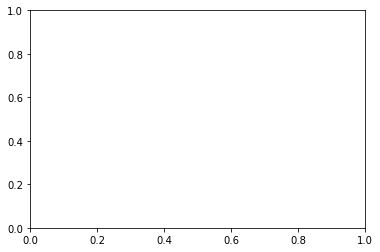

In [264]:
plt.scatter(X, Y, s=5, color="blue")
plt.show()

ValueError: x and y must be the same size

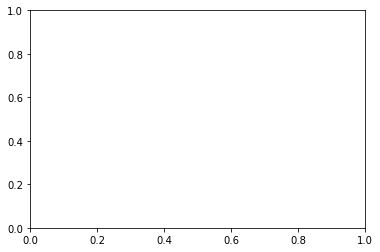

In [261]:
plt.scatter(X, Y.ravel(), s=5, color="blue", label="original")
plt.plot(X, y_pred, lw=2, color="red", label="fitted")
plt.legend()
plt.show()

In [78]:
y_pred = model_SVR.predict([[1,1,2021]])
y_pred = sc.inverse_transform(y_pred) 
y_pred

array([2503.81949544])

In [79]:
y_pred = regressor.predict([[4,1,2021]])
y_pred = sc.inverse_transform(y_pred) 
y_pred

array([2503.81949544])

In [130]:
X.shape

(22440, 3)

In [131]:
Y.shape 

(22440, 1)

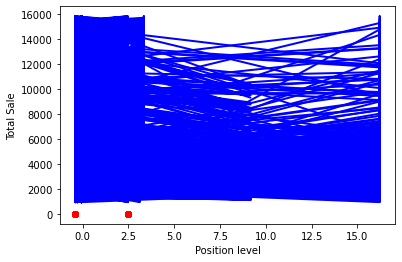

In [267]:
# Visualising the SVR results 
y_test y_predict
plt.plot(X, y_pred, lw=2, color = 'blue') 
plt.scatter(X[:,0], Y, color = 'red') 
plt.xlabel('Position level') 
plt.ylabel('Total Sale') 
plt.show()

In [ ]:
X_grid = np.arange(min(X), max(X), 0.01) #this step required because data is feature scaled.
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(X, y, color = 'red')
plt.plot(X_grid, regressor.predict(X_grid), color = 'blue')
plt.title('Truth or Bluff (SVR)')
plt.xlabel('Position level')
plt.ylabel('Salary')
plt.show()

# Linear Regression

In [95]:
df

,Item,Month,year,Total Sales
0,1,1,2014,1518
1,1,1,2015,3473
2,1,1,2016,3036
3,1,1,2017,3438
4,1,1,2018,3990
...,...,...,...,...
22435,264,12,2016,3555
22436,264,12,2017,3465
22437,264,12,2018,4680
22438,264,12,2019,3600


In [96]:
X

array([[-1.72550239, -1.56072175, -1.49773549],
       [-1.72550239, -1.56072175, -1.00620068],
       [-1.72550239, -1.56072175, -0.51466586],
       ...,
       [ 1.72550239,  1.59788179,  0.46840376],
       [ 1.72550239,  1.59788179,  0.95993858],
       [ 1.72550239,  1.59788179,  1.45147339]])

In [97]:
Y

array([[-1.25789012],
       [-0.48431538],
       [-0.65723208],
       ...,
       [-0.00671706],
       [-0.4340627 ],
       [ 0.66991354]])

In [106]:
X_train, X_test, y_train,y_test = train_test_split(X, Y, test_size = 0.2, random_state = 10)


In [107]:
X_train

array([[-0.16402114,  0.44929868,  0.95993858],
       [ 1.38433842, -0.12499287,  1.45147339],
       [ 0.19026452,  0.73644446,  0.46840376],
       ...,
       [-0.2165079 ,  1.02359024,  1.45147339],
       [-0.05904761, -1.56072175,  0.46840376],
       [-1.30560827, -1.27357597,  0.46840376]])

In [108]:
 y_train

array([[-0.63349066],
       [-0.18715188],
       [-0.3925152 ],
       ...,
       [ 3.0226887 ],
       [-0.48471107],
       [-0.19348293]])

In [109]:
model_regressor = LinearRegression()
model_regressor.fit(X_train, y_train)

LinearRegression()

In [117]:
y_pred = model_regressor.predict([[2,3,2021]])
y_pred = sc.inverse_transform(y_pred) 
y_pred

array([[47741.49248967]])

In [118]:
y_pred = model_regressor.predict([[21,4,2021]])
y_pred = sc.inverse_transform(y_pred)
y_pred

array([[49025.69494828]])

In [119]:
#predecting the test set results
y_pred = model_regressor.predict(X_test)
y_pred = sc.inverse_transform(y_pred)
y_pred

array([[4745.51774303],
       [4689.94497316],
       [4549.45929932],
       ...,
       [4717.80604526],
       [4972.41819019],
       [4665.89546805]])

In [120]:
model_regressor.score(X_test,y_test)

0.0011194199606009425

In [121]:
X_train.shape

(17952, 3)

In [122]:
y_train.shape

(17952, 1)

In [125]:
first_input.shape

(26928,)

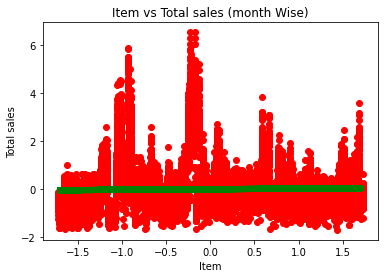

In [163]:
#Visualization of the training set results
plt.scatter(X_train[:,0], y_train, color = 'red')
plt.plot(X_train, model_regressor.predict(X_train), color = 'green')
plt.title('Item vs Total sales (month Wise)')
plt.xlabel('Item')
plt.ylabel('Total sales')
plt.show()

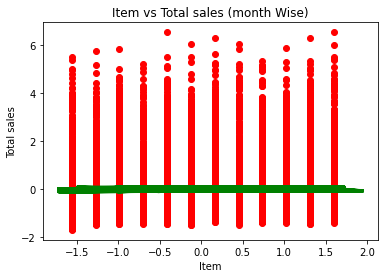

In [161]:
#Visualization of the training set results
plt.scatter(X_train[:,1], y_train, color = 'red')
plt.plot(X_train, model_regressor.predict(X_train), color = 'green')
plt.title('Item vs Total sales (month Wise)')
plt.xlabel('Item')
plt.ylabel('Total sales')
plt.show()


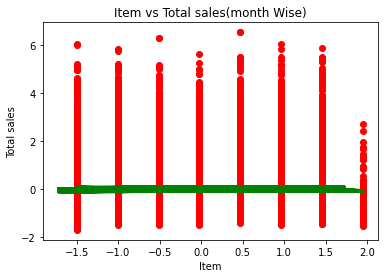

In [162]:
#Visualization of the training set results
plt.scatter(X_train[:,2], y_train, color = 'red')
plt.plot(X_train, model_regressor.predict(X_train), color = 'green')
plt.title('Item vs Total sales(month Wise)')
plt.xlabel('Item')
plt.ylabel('Total sales')
plt.show()

# Presenting 3 data in one Axis

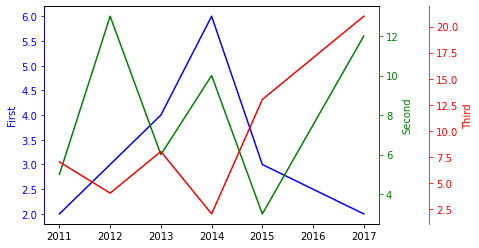

In [154]:
fig, ax1 = plt.subplots()

years = [2011,2012,2013,2014,2015,2017]
first = [2,3,4,6,3,2]
second = [5,13,6,10,3,12]
third = [7,4,8,2,13,21]

ax1.plot(years,first, color='blue')

ax2= ax1.twinx()
ax2.plot(years,second,color = 'green')

ax3= ax1.twinx()
ax3.plot(years,third,color = 'red')
#ax3.spines['right'].set_position(('outward',60))
ax3.spines['right'].set_position(('axes',1.15))

#
ax1.set_ylabel('First',color='blue')
ax2.set_ylabel('Second',color='green')
ax3.set_ylabel('Third',color='red')

#
ax1.tick_params(axis='y',colors='blue')
ax2.tick_params(axis='y',colors='green')
ax3.tick_params(axis='y',colors='red')

#
ax2.spines['right'].set_color("green")
ax3.spines['right'].set_color("red")
ax3.spines['left'].set_color("blue")

plt.show()

# fig.tight_layout() # alternate of  bbox_inches='tight'
fig.savefig("3-axis-test.png", bbox_inches='tight')


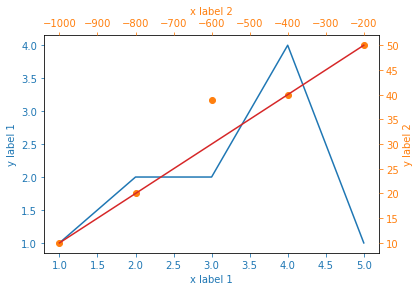

In [156]:
x_values1=[1,2,3,4,5]
y_values1=[1,2,2,4,1]

x_values2=[-1000,-800,-600,-400,-200]
y_values2=[10,20,39,40,50]

x_values3=[150,200,250,300,350]
y_values3=[10,20,30,40,50]


fig=plt.figure()
ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)
ax3=fig.add_subplot(111, label="3", frame_on=False)

ax.plot(x_values1, y_values1, color="C0")
ax.set_xlabel("x label 1", color="C0")
ax.set_ylabel("y label 1", color="C0")
ax.tick_params(axis='x', colors="C0")
ax.tick_params(axis='y', colors="C0")

ax2.scatter(x_values2, y_values2, color="C1")
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlabel('x label 2', color="C1") 
ax2.set_ylabel('y label 2', color="C1")       
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='x', colors="C1")
ax2.tick_params(axis='y', colors="C1")

ax3.plot(x_values3, y_values3, color="C3")
ax3.set_xticks([])
ax3.set_yticks([])

plt.show()

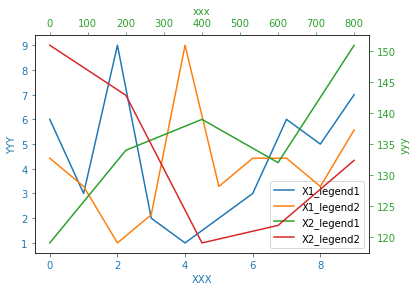

In [158]:
X1 = np.arange(10)
X1 = np.stack([X1, X1])
Y1 = np.random.randint(1, 10, (2, 10))
X2 = np.arange(0, 1000, 200)
X2 = np.stack([X2, X2])
Y2 = np.random.randint(100, 200, (2, 5))


x_label_names = ['XXX', 'xxx']
y_label_names = ['YYY', 'yyy']
X1_legend_names = ['X1_legend1', 'X1_legend2']
X2_legend_names = ['X2_legend1', 'X2_legend2']


def plot_by_two_xaxis(X1, Y1, X2, Y2, x_label_names: list, y_label_names: list, X1_legend_names: list, X2_legend_names: list):
    fig = plt.figure()
    ax1s = []
    ax2s = []
    lines = []
    j = 0
    for i in range(len(X1)):
        j += 1
        ax1s.append(fig.add_subplot(111, label=f"{j}", frame_on=(j == 1)))
    for i in range(len(X2)):
        j += 1
        ax2s.append(fig.add_subplot(111, label=f"{j}", frame_on=(j == 1)))

    k = 0
    for i in range(len(X1)):
        lines.append(ax1s[i].plot(X1[i], Y1[i], color=f"C{k}")[0])
        if i == 0:
            ax1s[i].set_xlabel(x_label_names[0], color=f"C{k}")
            ax1s[i].set_ylabel(y_label_names[0], color=f"C{k}")
            ax1s[i].tick_params(axis='x', colors=f"C{k}")
            ax1s[i].tick_params(axis='y', colors=f"C{k}")
        else:
            ax1s[i].set_xticks([])
            ax1s[i].set_yticks([])
        k += 1

    for i in range(len(X1)):
        lines.append(ax2s[i].plot(X2[i], Y2[i], color=f"C{k}")[0])
        if i == 0:
            ax2s[i].xaxis.tick_top()
            ax2s[i].yaxis.tick_right()
            ax2s[i].set_xlabel(x_label_names[1], color=f"C{k}")
            ax2s[i].set_ylabel(y_label_names[1], color=f"C{k}")
            ax2s[i].xaxis.set_label_position('top')
            ax2s[i].yaxis.set_label_position('right')
            ax2s[i].tick_params(axis='x', colors=f"C{k}")
            ax2s[i].tick_params(axis='y', colors=f"C{k}")
        else:
            ax2s[i].set_xticks([])
            ax2s[i].set_yticks([])
        k += 1

    ax1s[0].legend(lines, X1_legend_names + X2_legend_names)

    plt.show()


plot_by_two_xaxis(X1, Y1, X2, Y2, x_label_names,
                y_label_names, X1_legend_names, X2_legend_names)